In [1]:
"""
This notebook analyzes the resulting data
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Disregard depecation warnings
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*is_categorical_dtype is deprecated.*"
)


In [4]:
def basic_info(label_name):
    print("-- Preprocessed dataset --")
    
    # Load in the previous dataset
    dataset = pd.read_parquet("../df_preprocessed.parquet")
    
    # Get the number of missing values
    print(f"# of Missing/NaN values: {len(dataset.loc[dataset[label_name].isna()])}")

    # Get the value count for the label in percentages
    print("\nValue counts (%): ")
    print(dataset[label_name].value_counts(normalize=True) * 100)
    

    print("\n\n-- Final dataset --")
    
    # Load in the final dataset
    dataset = pd.read_parquet("../df_preprocessed_with_predictions2.parquet")
    
    # Get the number of missing values
    print(f"# of Missing/NaN values: {len(dataset.loc[dataset[label_name].isna()])}")

    # Get the value count for the label in percentages
    print("\nValue counts (%): ")
    print(dataset[label_name].value_counts(normalize=True) * 100)

    return dataset

In [7]:
def tsne(cleaned):
    # T-SNE
    from sklearn.manifold import TSNE
    
    # Drop rows with any remaining NaNs (or use .fillna() if you prefer imputation)
    #print(f"NaN remaining: {len(cleaned.dropna())}")
    #cleaned = cleaned.dropna()
    
    # Reduce size for performance – t-SNE is O(n^2)
    MAX_ROWS = 50000
    if len(cleaned) > MAX_ROWS:
        cleaned = cleaned.sample(MAX_ROWS, random_state=123)
        print(f"Sampled {MAX_ROWS} rows for t-SNE (original: {len(cleaned)})")
    
    # Run t-SNE
    X_tsne = TSNE(n_components=2, random_state=123, perplexity=30).fit_transform(cleaned)
    
    # Plot
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=3, alpha=0.7)
    plt.title("t-SNE visualization (with satjob & satfin)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()


In [9]:
def histograms(cleaned):
    # Visualize distributions of values
    col_names = list(["satjob", "satfin"])
    for col in col_names:
        sns.histplot(cleaned[col].dropna(), kde=True)
        plt.title(col)
        plt.show()

In [11]:
def scatter_plot(cleaned):
    col_names = list(["satjob", "satfin"])
    
    for i in col_names:
        for j in cleaned.columns:
            sns.scatterplot(
                data=cleaned,
                x=i,   # choose your x-axis column
                y=j,    # choose your y-axis column
                alpha=0.6
            )
            plt.title(f"Scatter plot: {i} vs {j}")
            plt.show()

In [13]:
def time_corr(cleaned, label_name):
    # Compute yearly means
    yearly = cleaned.groupby('year')[label_name].mean()
    
    # Plot
    # Satfin: 1 is happy, 2 is somewhat happy, 3 is not happy with the financial situation
    # Satjob: 1 is happy, 2 is somewhat happy, 3 is somewhat not happy, 4 is not happy with the job
    yearly.plot(marker='o')
    if(label_name == "satfin"):
        plt.ylabel("Mean value(1 is happy, 3 is not happy)")
        plt.title("Mean financial satisfaction over time")
    else:
        plt.ylabel("Mean value(1 is happy, 4 is not happy)")
        plt.title("Mean job satisfaction over time")
    plt.show()

In [15]:
def heat_map(cleaned):
    # Compute correlations
    hm = cleaned.select_dtypes(include="number").corr()
    print(hm)

    # Plot
    plt.figure(figsize=(15,15))
    sns.heatmap(hm, annot=True)

In [29]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

def format_rules(rules, top_k=10):
    # Get the top-k rules
    df = rules.copy()
    if top_k is not None:
        df = df.head(top_k)

    # Agregate adn format the rules into easy to interpret lines
    lines = []
    for _, row in df.iterrows():
        ant = " & ".join(sorted(map(str, row["antecedents"])))
        cons = " & ".join(sorted(map(str, row["consequents"])))
        line = (
            f"{ant}  →  {cons}  "
            f"(support={row['support']:.3f}, "
            f"confidence={row['confidence']:.3f}, "
            f"lift={row['lift']:.3f})"
        )
        lines.append(line)
    return lines

def to_sparse_onehot_items(df, target_col="satjob"):
    # Get the features from everywhere besides the target
    feature_cols = [c for c in df.columns if c != target_col]

    # Construct the syntax
    X = df[feature_cols].copy()
    for c in feature_cols:
        X[c] = c + "=" + X[c].astype(str)

    X[target_col] = target_col + "=" + df[target_col].astype(str)

    # Create the holder
    oh = pd.get_dummies(X, prefix="", prefix_sep="", sparse=True)

    # Convert to bool (required by mlxtend)
    oh = oh.astype(bool)

    return oh


# Mine rules with consequent = target_col=target_value
def fp_tree( oh, target_col="satjob", min_support=0.05, min_conf=0.7, max_len=3):
    # Mine itemsets
    itemsets = fpgrowth(
        oh,
        min_support=min_support,
        use_colnames=True,
        max_len=max_len
    )

    # If no itemsets, return an empty set
    if itemsets.empty:
        return pd.DataFrame(columns=[
            "antecedents", "consequents",
            "support", "confidence", "lift"
        ])

    # Generate all rules
    rules = association_rules(
        itemsets,
        metric="confidence",
        min_threshold=min_conf,
        support_only=False
    )

    # If no association rules, stop
    if rules.empty:
        return pd.DataFrame(columns=[
            "antecedents", "consequents",
            "support", "confidence", "lift"
        ])

    # Keep only rules where consequent contains ANY target=* item
    rules = rules[
        rules["consequents"].apply(
            lambda s: any(str(i).startswith(f"{target_col}=") for i in s)
        )
    ]

    # Remove rules where target=* appears in the antecedent
    rules = rules[
        ~rules["antecedents"].apply(
            lambda s: any(str(i).startswith(f"{target_col}=") for i in s)
        )
    ]

    # If no rules after the filtering, stop
    if rules.empty:
        return pd.DataFrame(columns=[
            "antecedents", "consequents",
            "support", "confidence", "lift"
        ])

    # Sort to get the best first
    metrics = {"lift", "confidence", "support"}
    if metrics.issubset(rules.columns):
        rules = rules.sort_values(
            ["lift", "confidence", "support"],
            ascending=False
        )

    return rules



In [24]:
def analyze( label_name ):

    # Output the corresponding information and check if the target is correct
    if label_name == "satjob":
        print("The meaning of the values for satjob:\n\t1-Very satisfied\n\t2-Moderately satisfied\n\t3-A little dissatisfied\n\t4-Very dissatisfied")
    elif label_name == "satfin":
        print("The meaning of the values for satfin:\n\t1-Very satisfied\n\t2-Moderately satisfied\n\t3-Not satisfied at all")
    else:
        raise RuntimeError("Wrong label(target) name")

    # Compare the preprocessed and the final datasets
    dataset = basic_info(label_name)
    cleaned = dataset
    
    #T-sne
    print("\nT-SNE")
    tsne(cleaned)

    # Histograms
    print("\nHistograms")
    histograms(cleaned)

    # Scatter plots
    print("\nScatter plots")
    scatter_plot(cleaned)

    # Time correlations
    print("\nTime correlation. How does {label_name} correlates to / changes in each year?")
    time_corr(cleaned, label_name)

    # Heatmap
    print("\nHeatmap")
    heat_map(cleaned)
    
    # Finding common patterns with FP-tree (e.g., what kind of degree brings satisfaction)
    print(f"\n\n\n--- FP tree ---")
    chunk_size = 50_000
    item_min_support = 0.05
    rule_min_support = 0.50
    rules_per_chunk = 5

    # Pre-allocate the array to lower the comp.cost. Resulting array's size = # of chunks ceiled
    n_chunks = ((len(cleaned) + chunk_size - 1) // chunk_size)
    all_rules = [None]*n_chunks

    # Since we have such a huge dataset, we will analyze the dataset in chunks
    for i in range(0, n_chunks):
        print(f"Chunk#{i}")

        # Get a chunk
        i_chunk = i*chunk_size
        chunk = cleaned.iloc[i_chunk:i_chunk+chunk_size]
        if chunk.empty:
            break

        # Conver it into hot-encodings(booleans) suitable for the FP_GROWTH alg.
        oh = to_sparse_onehot_items(chunk, target_col=label_name)

        # Drop the rare item right way, so that FP_GROWTH has lower comp.cost
        item_supports = oh.mean(axis=0)

        target_prefix = f"{label_name}="
        is_target = item_supports.index.to_series().str.startswith(target_prefix)
        
        # keep: frequent enough AND not constant (not ~0, not ~1)
        eps = 1e-9
        keep = ((item_supports >= item_min_support) & (item_supports <= 1 - eps))
        
        # always keep target cols (optional)
        keep = keep | is_target
        
        oh = oh.loc[:, item_supports.index[keep]]

        #print("cols before:", item_supports.size, "cols after:", oh.shape[1], "max support (non-target):", item_supports[~item_supports.index.to_series().str.startswith(f"{label_name}=")].max())


        # Mine the rules
        rules = fp_tree(
            oh,
            target_col=label_name,
            min_support=rule_min_support,
            min_conf=0.6,
            max_len=3,
        )

        if rules.empty or "lift" not in rules.columns:
            print("  -> no rules in this chunk")
            continue

        # Sort the output in descending order
        rules = rules.sort_values(
            by=["lift", "confidence", "support"],
            ascending=[False, False, False]
        )
        if rules.empty:
            print("  -> no rules in this chunk")
            continue

        # Get the top-rules_per_chunk(e.g., 5) rules of this chunk
        top5 = rules.head(rules_per_chunk)
    
        # Save them to be analyzed later
        all_rules[i] = top5


    # Get rid off Nones
    all_rules = [r for r in all_rules if r is not None]

    # Combine all top-5-per-chunk into one DataFrame
    if len(all_rules) > 0:
        global_rules = pd.concat(all_rules, ignore_index=True)
    else:
        global_rules = pd.DataFrame()

    # Sort to get the best
    global_rules = global_rules.sort_values(
        by=["lift", "confidence", "support"],
        ascending=[False, False, False]
    )

    # Get top10
    top10_global = global_rules.head(10)

    # Fromat and print the results
    print("\nAssociation rules:")
    for s in format_rules(top10_global, top_k=10):
        print(s)




    # Evaluation / Interpretation of the results is done in the presentation 2


The meaning of the values for satjob:
	1-Very satisfied
	2-Moderately satisfied
	3-A little dissatisfied
	4-Very dissatisfied
-- Preprocessed dataset --
# of Missing/NaN values: 15319701

Value counts (%): 
satjob
1.0    48.542459
2.0    38.457360
3.0     8.890096
4.0     4.110085
Name: proportion, dtype: float64


-- Final dataset --
# of Missing/NaN values: 0

Value counts (%): 
satjob
1.0    90.746902
2.0     9.248413
3.0     0.003204
4.0     0.001481
Name: proportion, dtype: float64

T-SNE
Sampled 50000 rows for t-SNE (original: 50000)


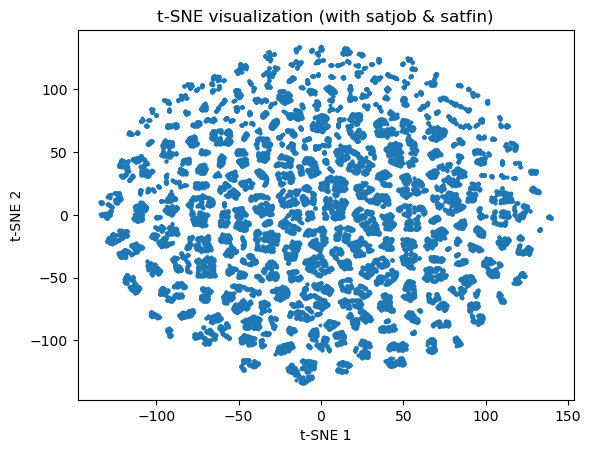


Histograms


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


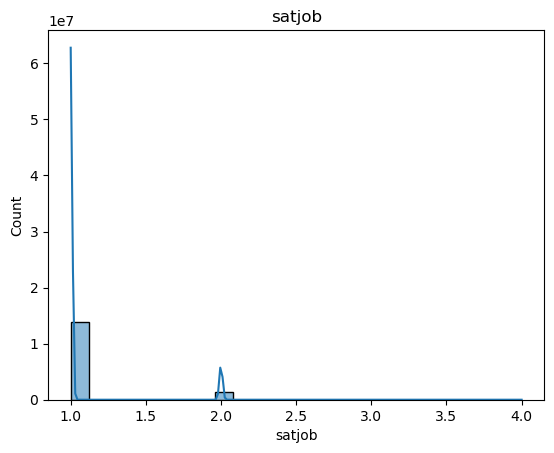

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


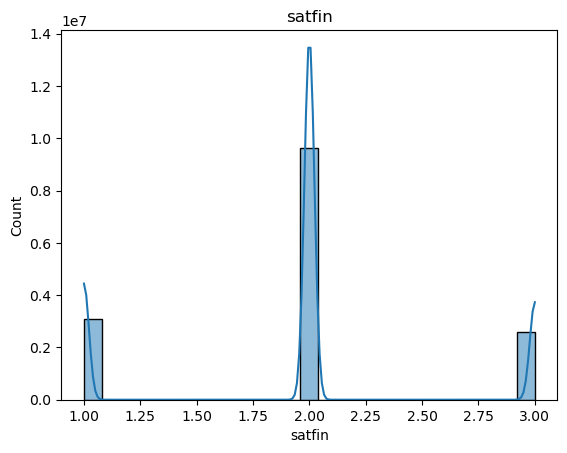


Scatter plots


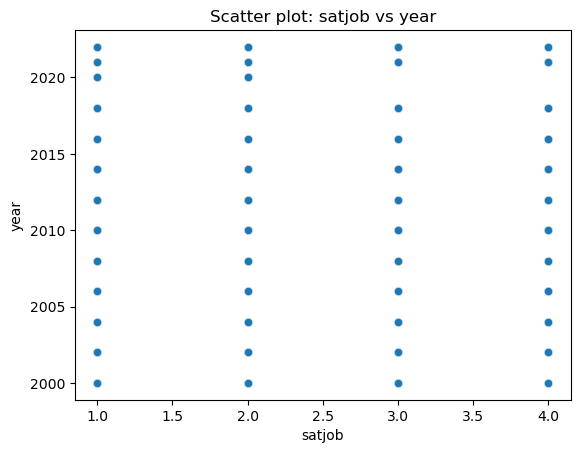

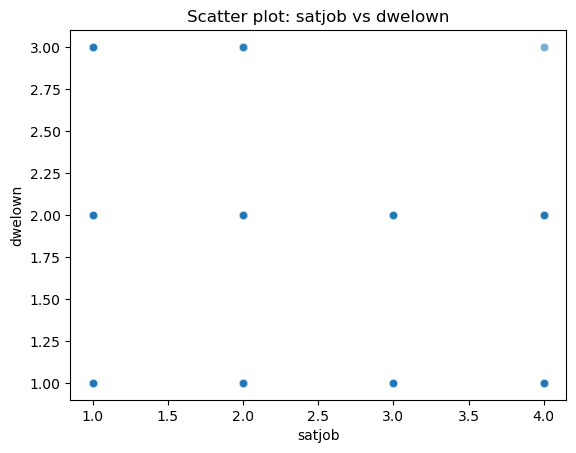

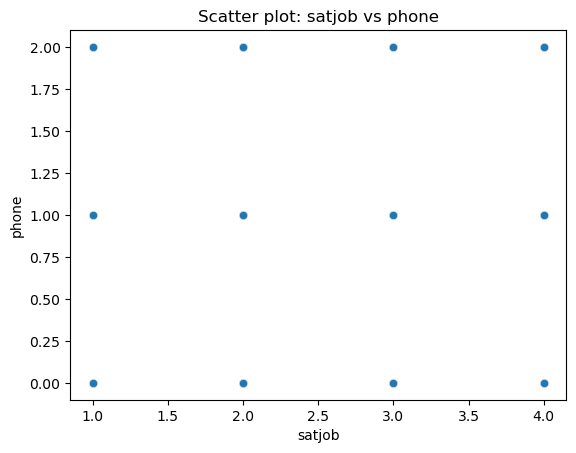

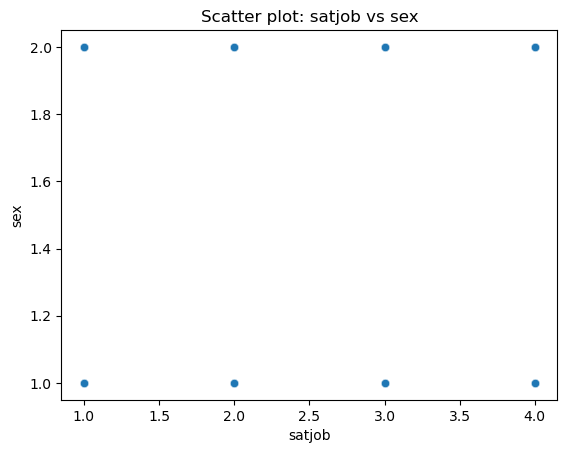

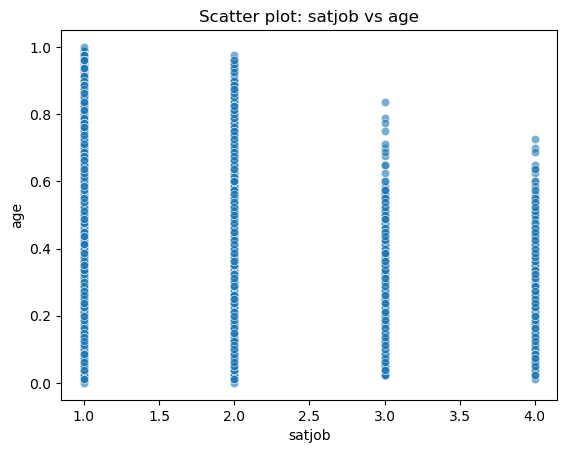

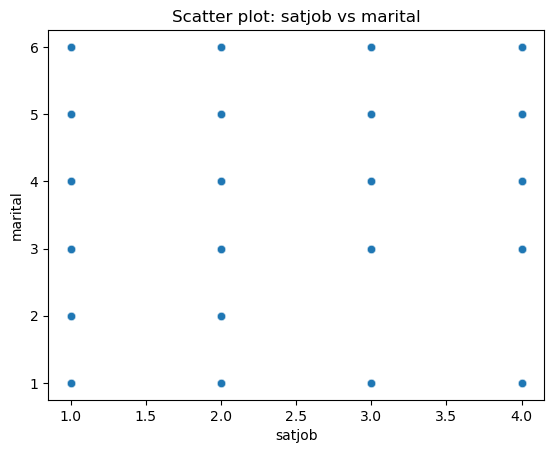

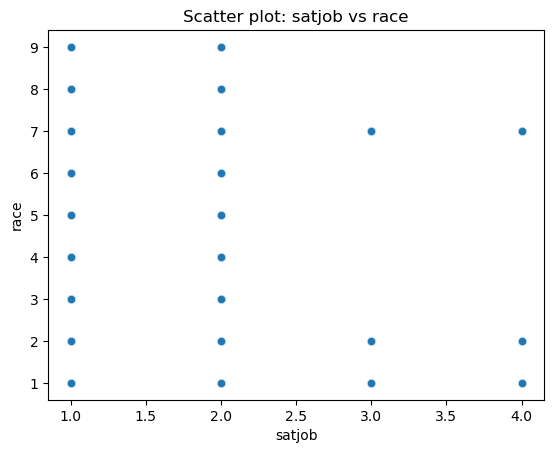

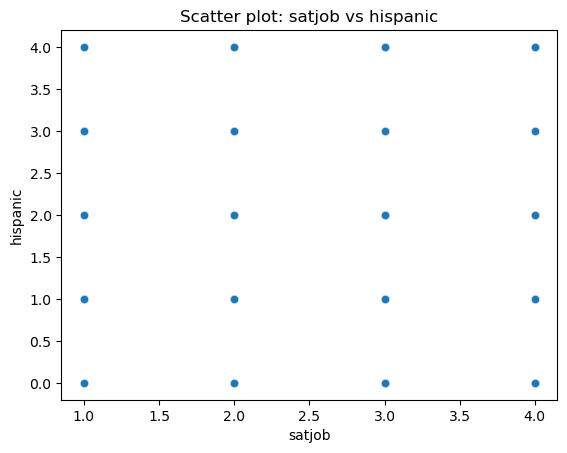

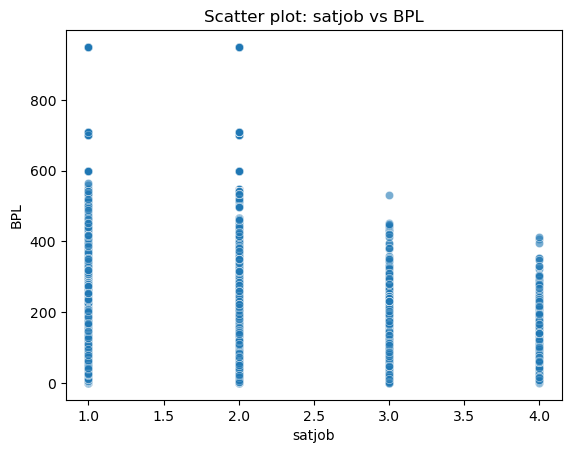

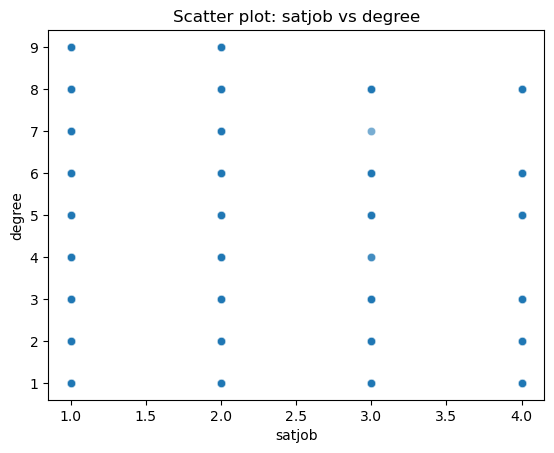

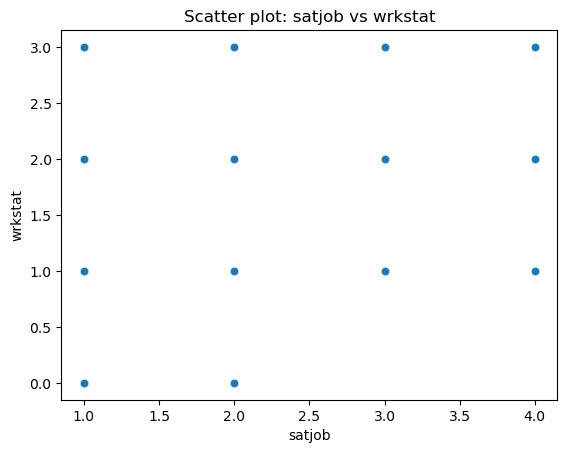

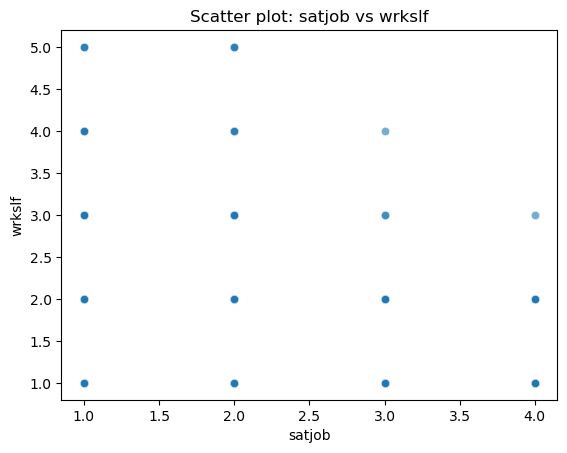

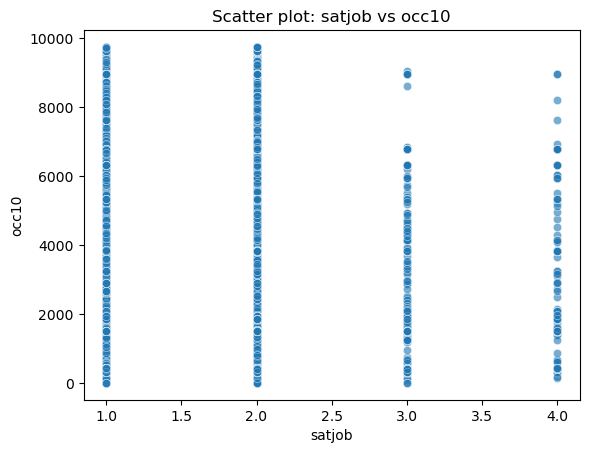

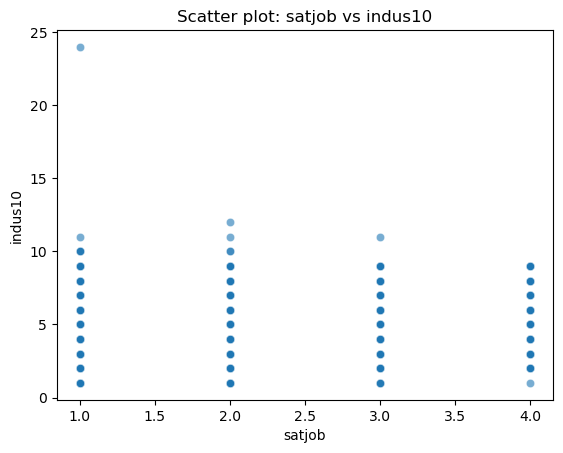

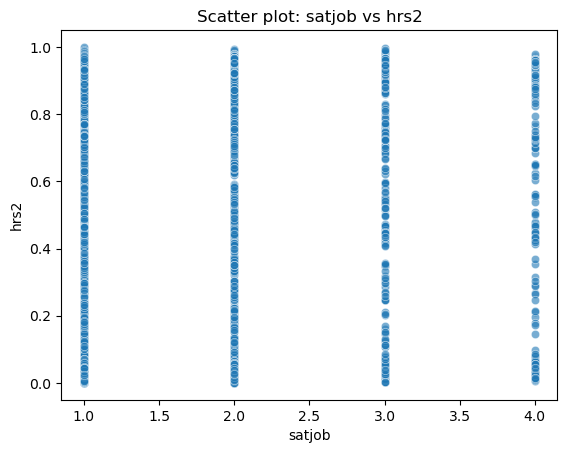

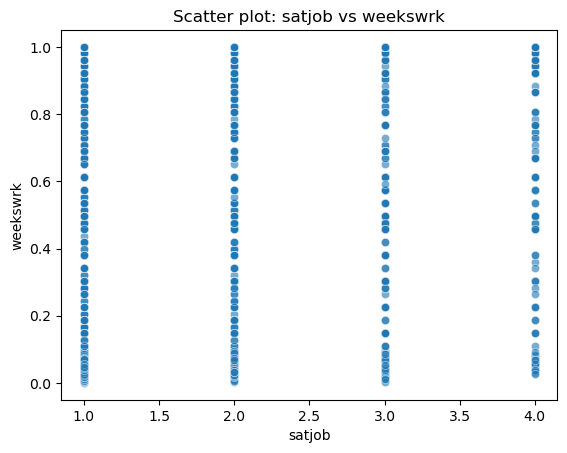

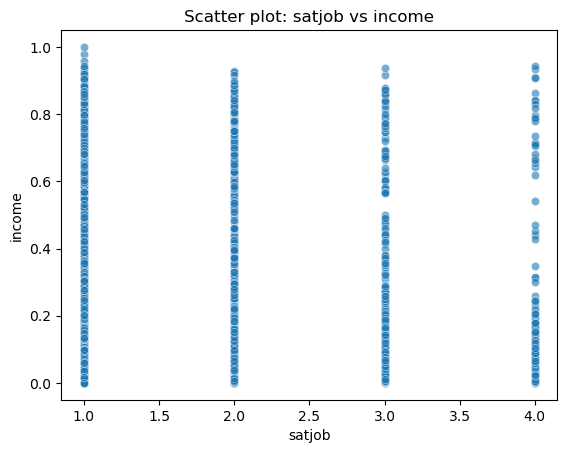

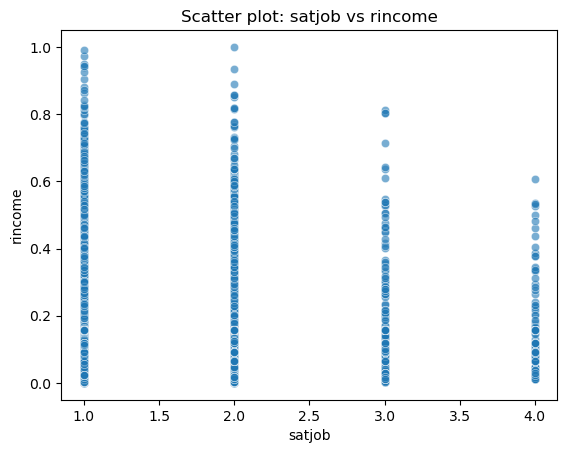

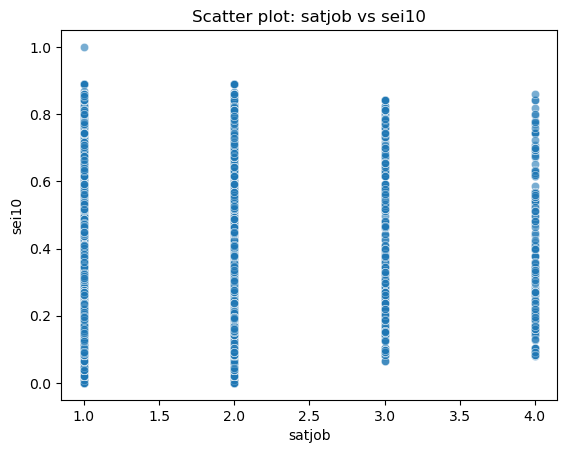

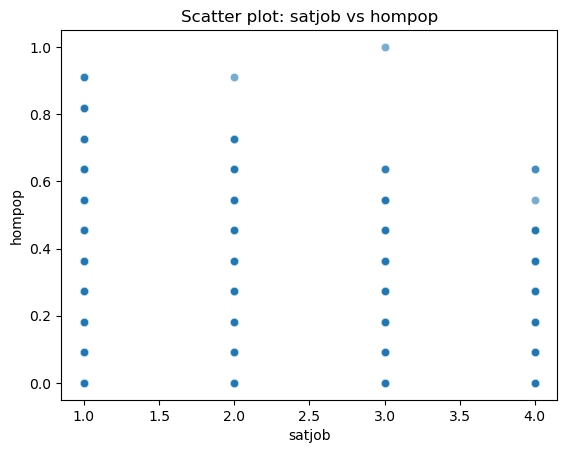

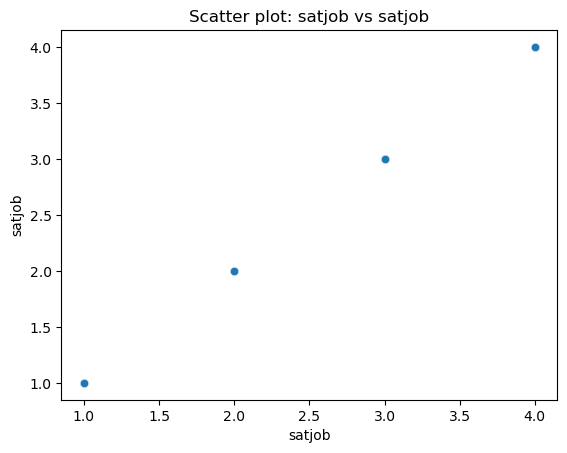

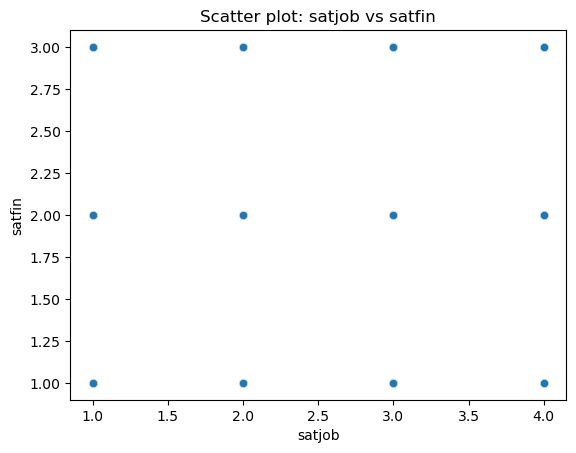

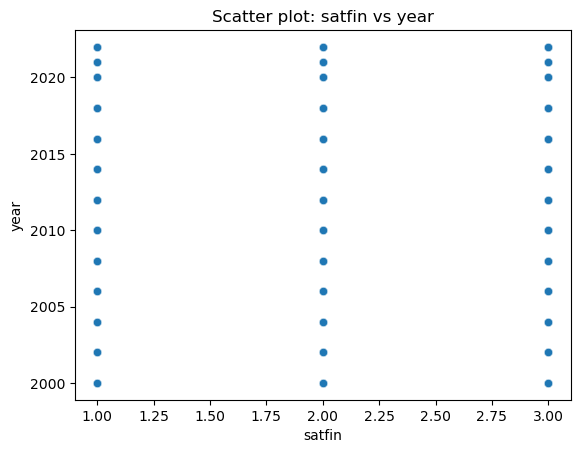

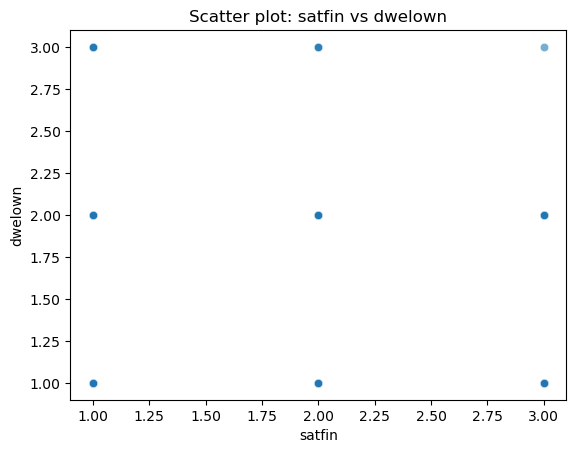

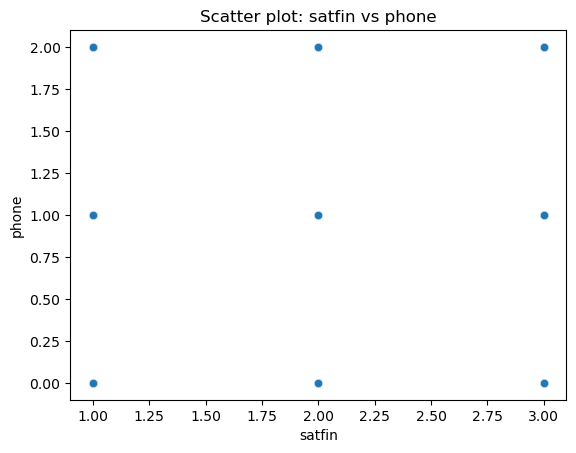

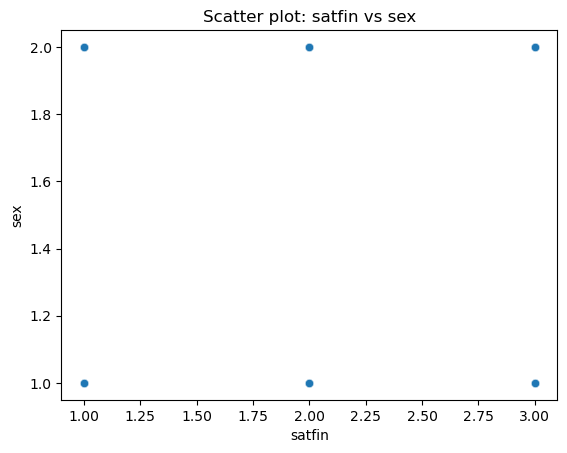

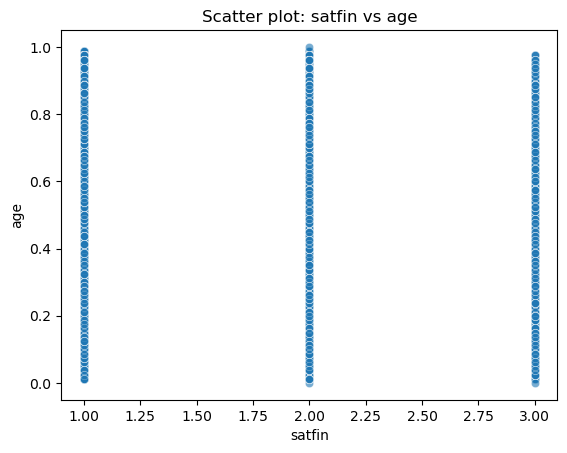

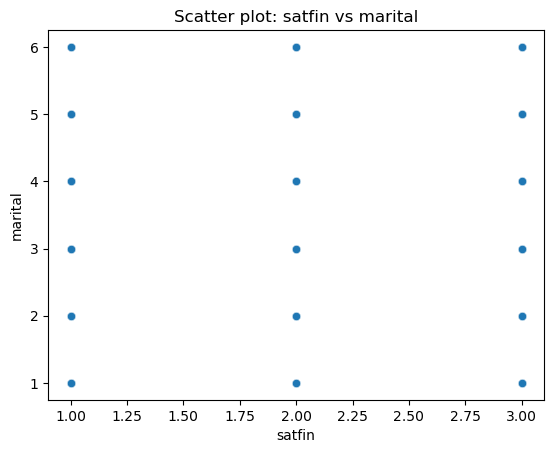

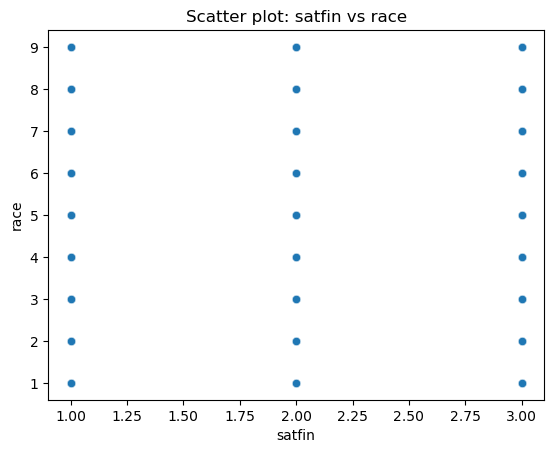

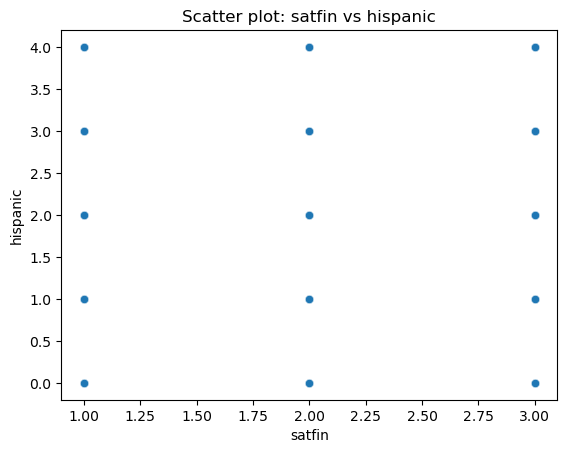

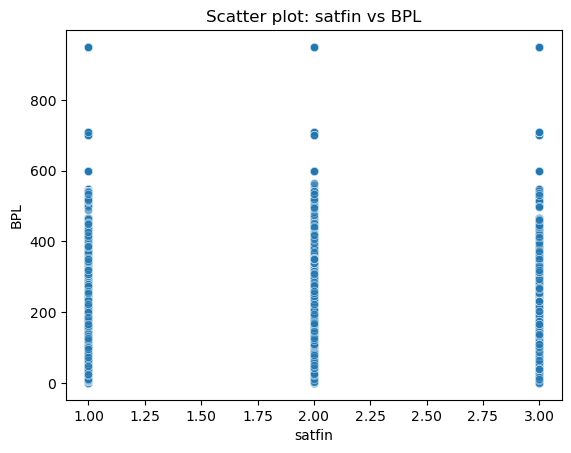

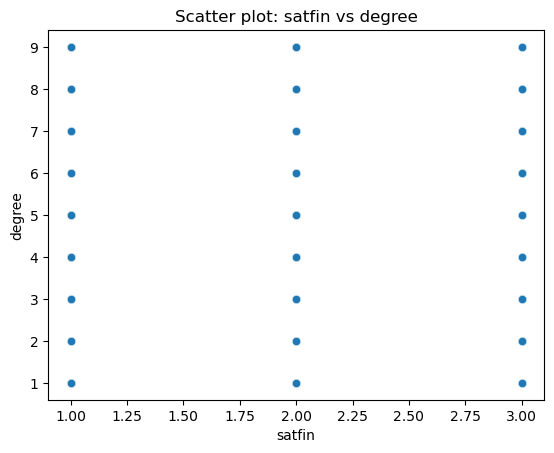

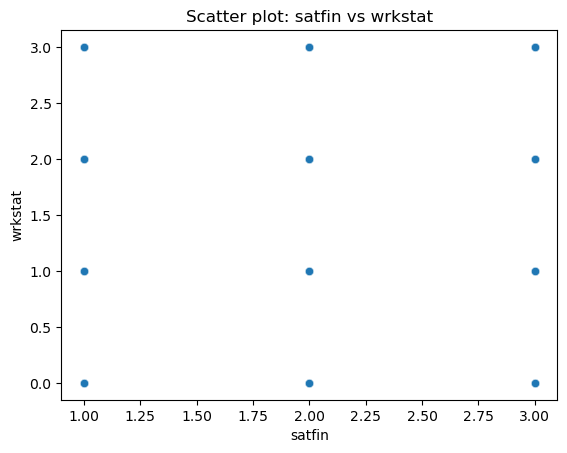

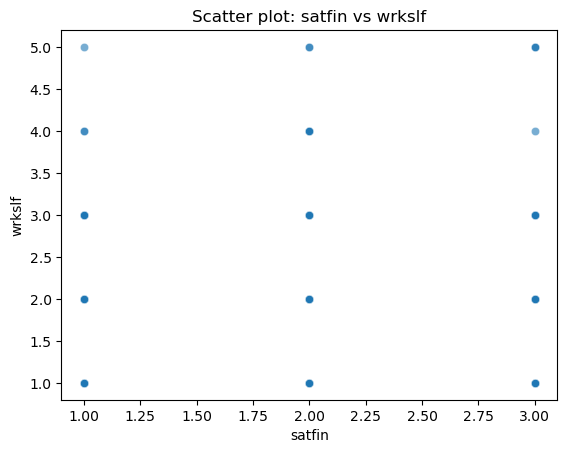

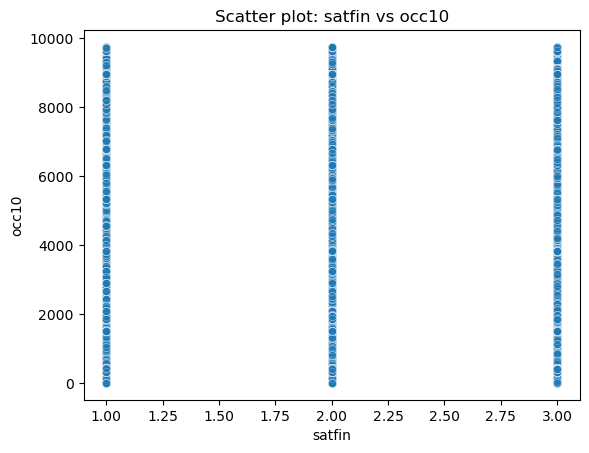

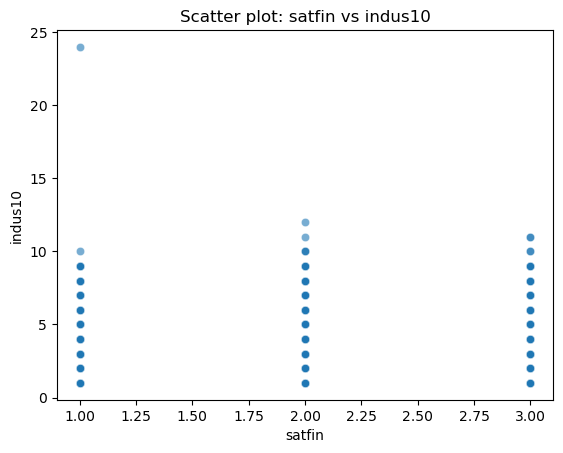

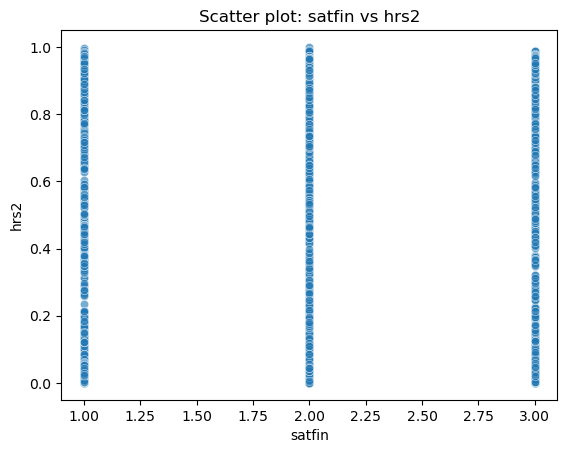

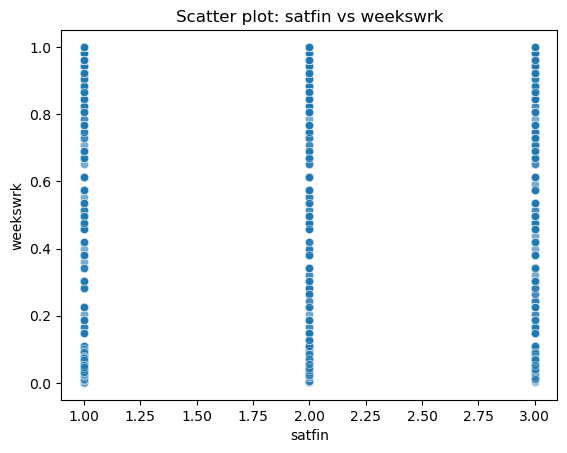

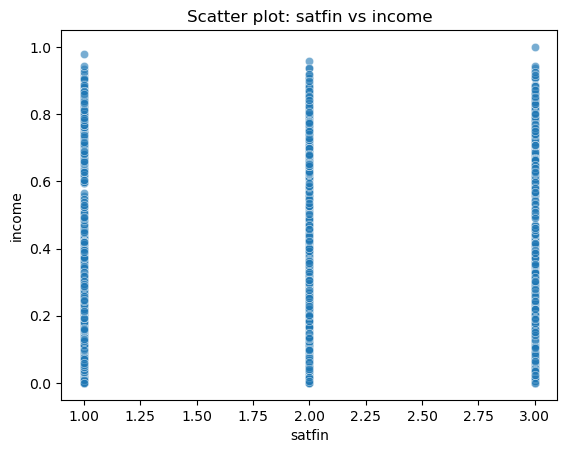

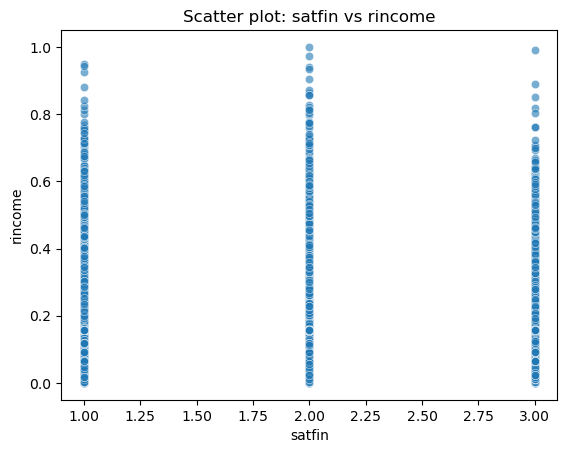

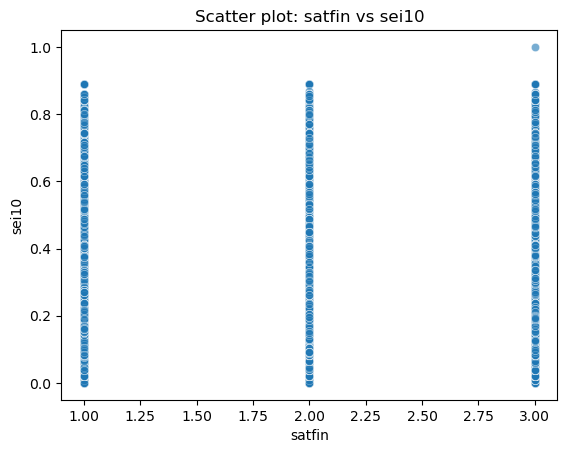

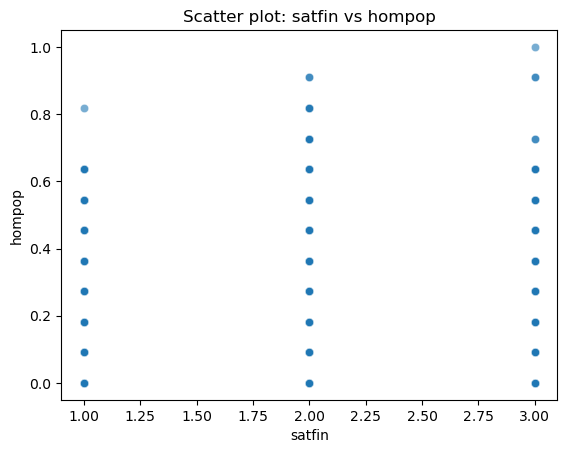

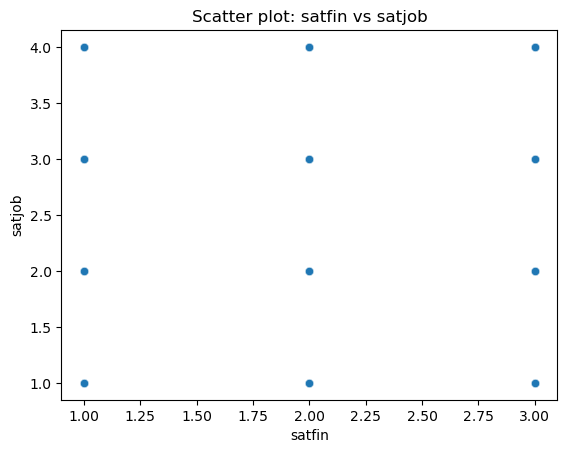

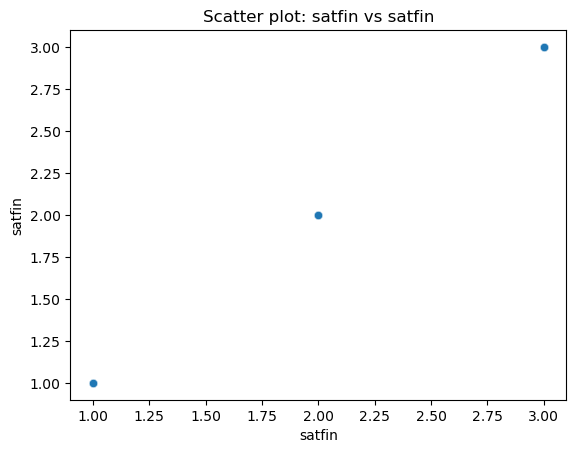


Time correlation. How does {label_name} correlates to / changes in each year?


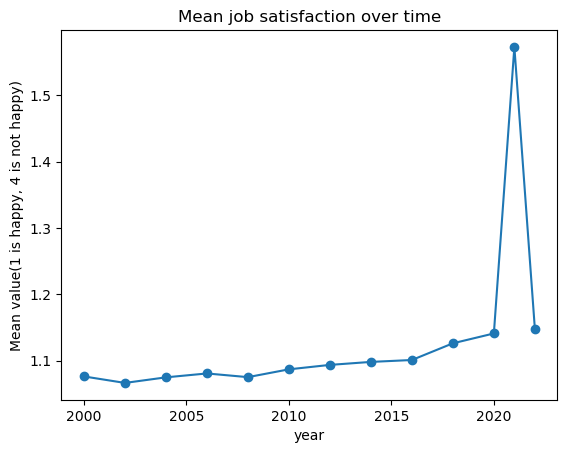


Heatmap
              year   dwelown     phone       sex       age   marital  \
year      1.000000  0.016693  0.016872  0.006632  0.080323  0.071640   
dwelown   0.016693  1.000000 -0.087769  0.006575 -0.254894  0.274438   
phone     0.016872 -0.087769  1.000000  0.014269  0.051994 -0.061410   
sex       0.006632  0.006575  0.014269  1.000000 -0.000250  0.022275   
age       0.080323 -0.254894  0.051994 -0.000250  1.000000 -0.288694   
marital   0.071640  0.274438 -0.061410  0.022275 -0.288694  1.000000   
race      0.090988  0.130759 -0.017551 -0.000834 -0.103082  0.063532   
hispanic  0.045442  0.109907 -0.018439 -0.005346 -0.083494  0.043174   
BPL       0.031949  0.085462 -0.000280 -0.010237 -0.007882 -0.044377   
degree    0.032776 -0.062166  0.045784  0.056078  0.023826 -0.063525   
wrkstat  -0.139382  0.003665 -0.016353  0.050868  0.119205 -0.010581   
wrkslf   -0.007653  0.060061 -0.010252  0.083757 -0.139669  0.073933   
occ10    -0.052942  0.043532 -0.035533 -0.156505 -0.035

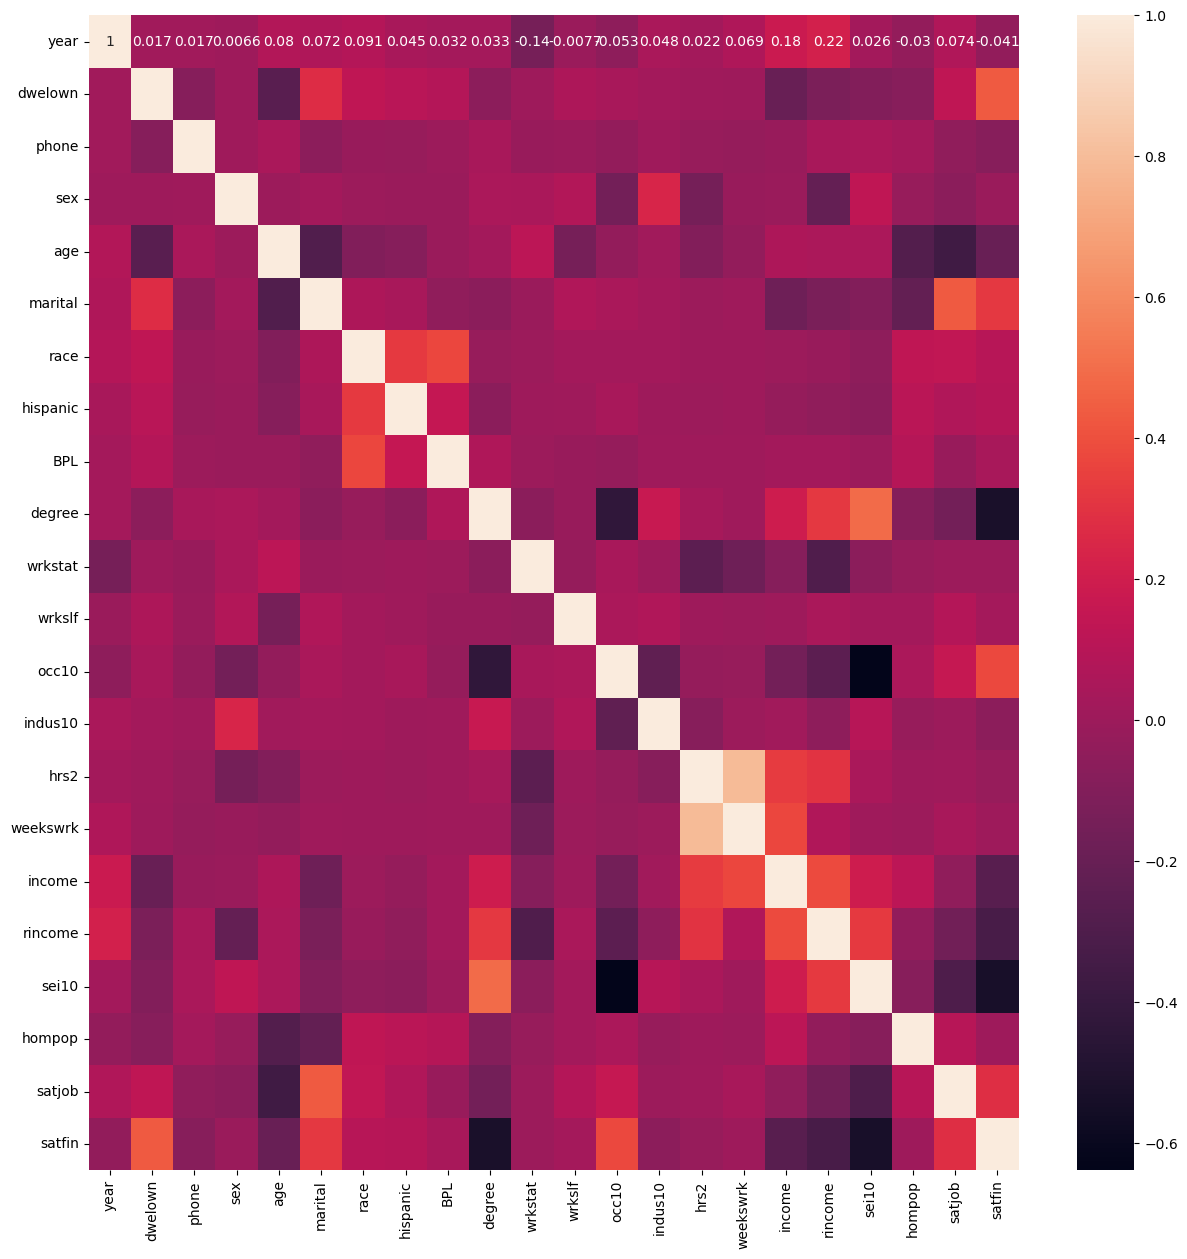

In [26]:
# Satjob
analyze("satjob")

The meaning of the values for satfin:
	1-Very satisfied
	2-Moderately satisfied
	3-Not satisfied at all
-- Preprocessed dataset --
# of Missing/NaN values: 15318495

Value counts (%): 
satfin
2.0    44.865508
1.0    30.257096
3.0    24.877396
Name: proportion, dtype: float64


-- Final dataset --
# of Missing/NaN values: 0

Value counts (%): 
satfin
2.0    62.829059
1.0    20.205630
3.0    16.965312
Name: proportion, dtype: float64

T-SNE
Sampled 50000 rows for t-SNE (original: 50000)


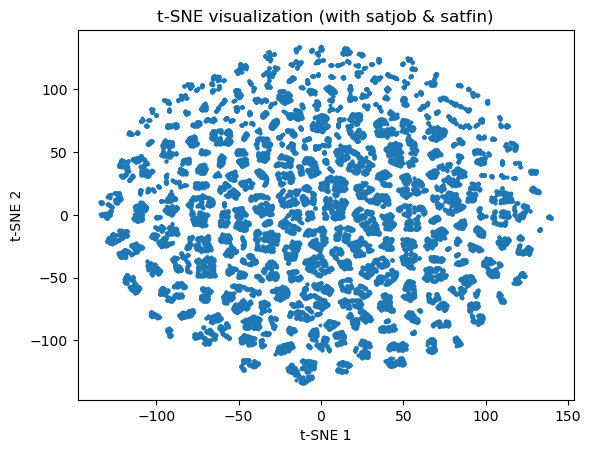


Histograms


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


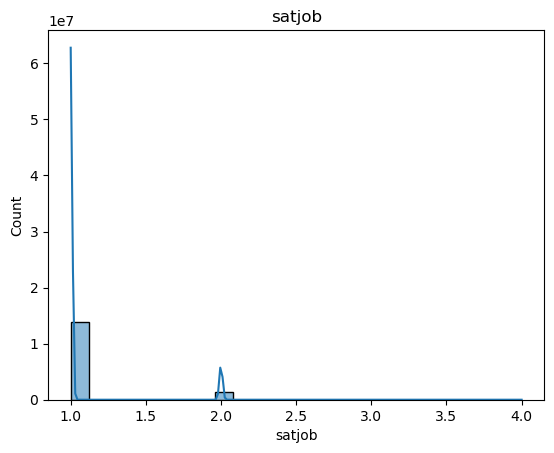

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


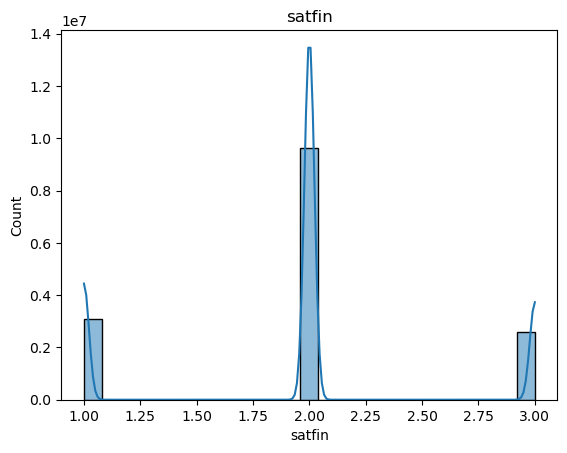


Scatter plots


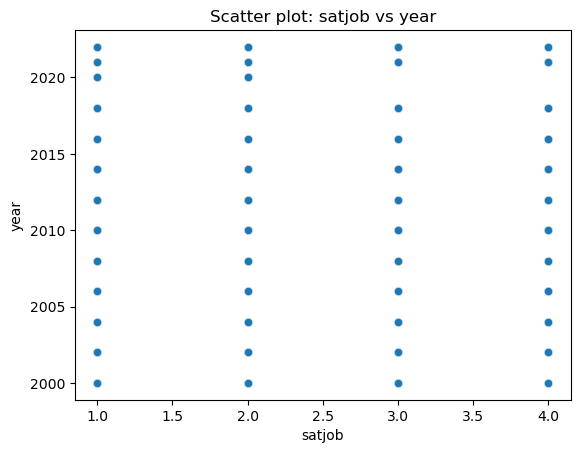

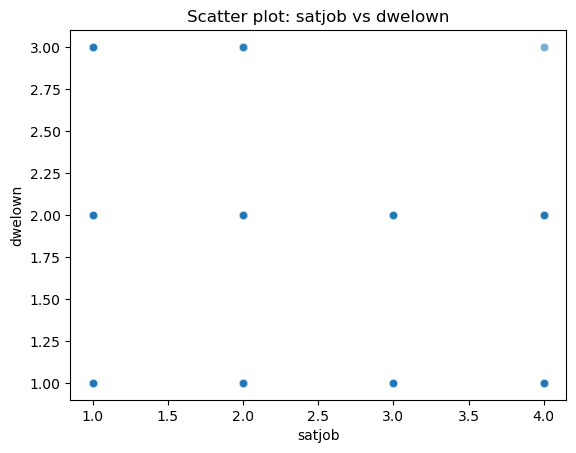

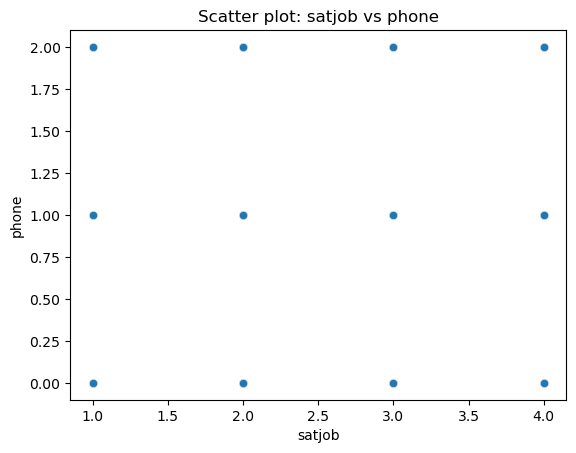

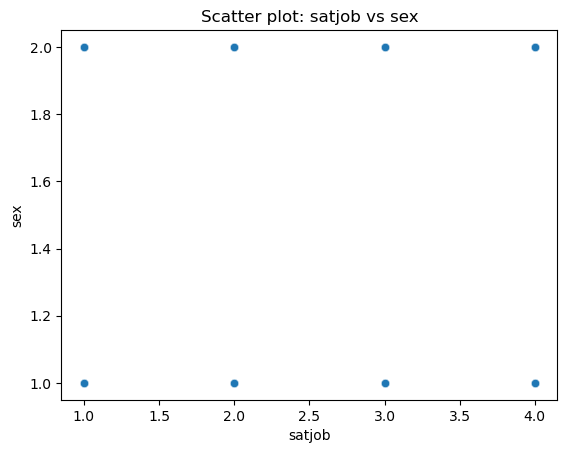

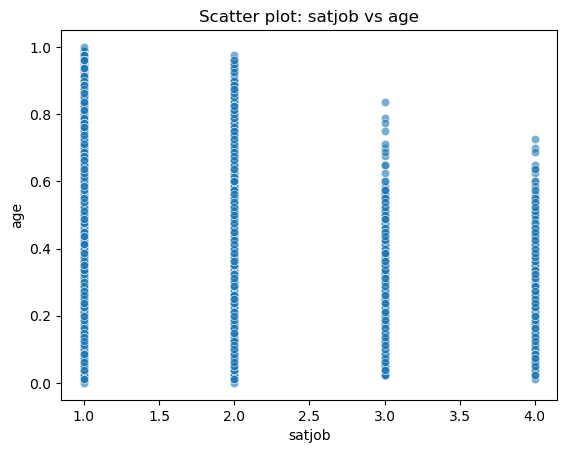

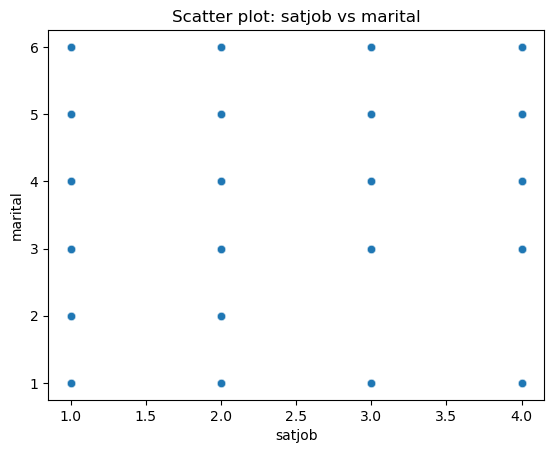

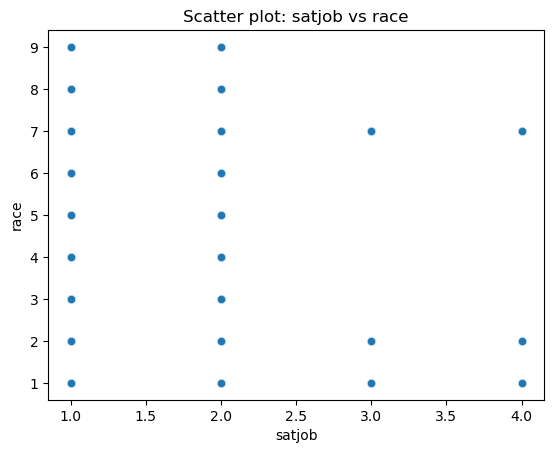

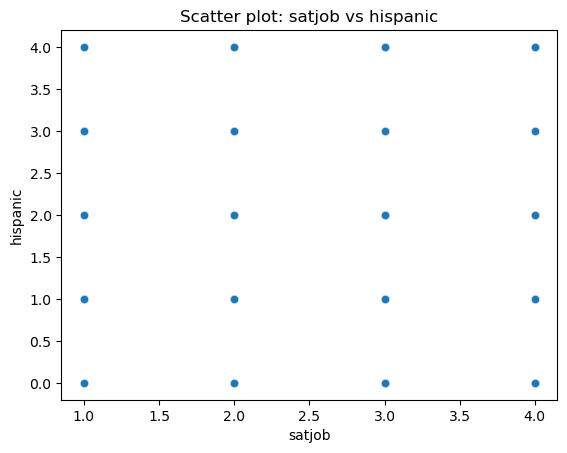

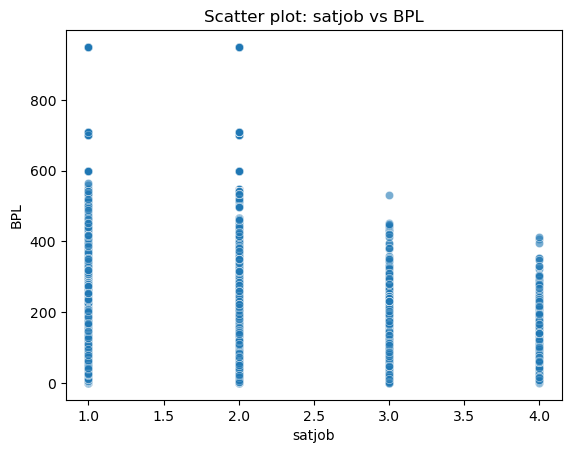

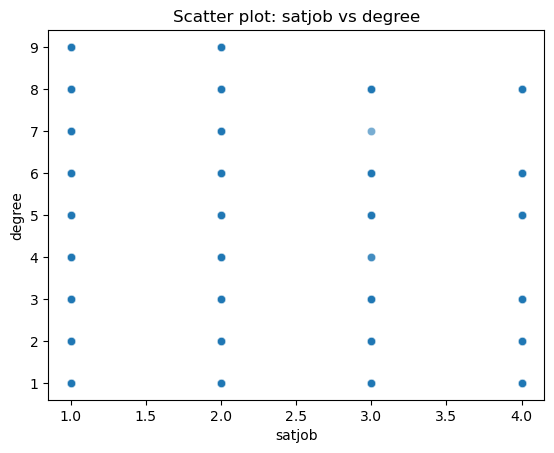

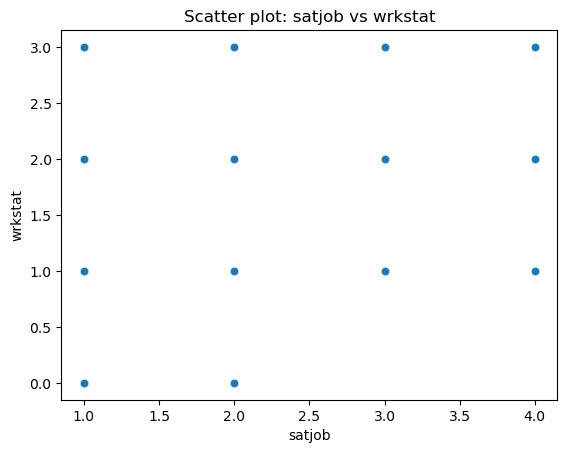

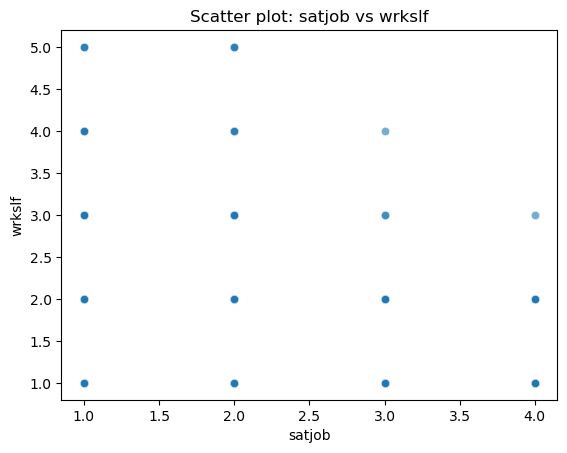

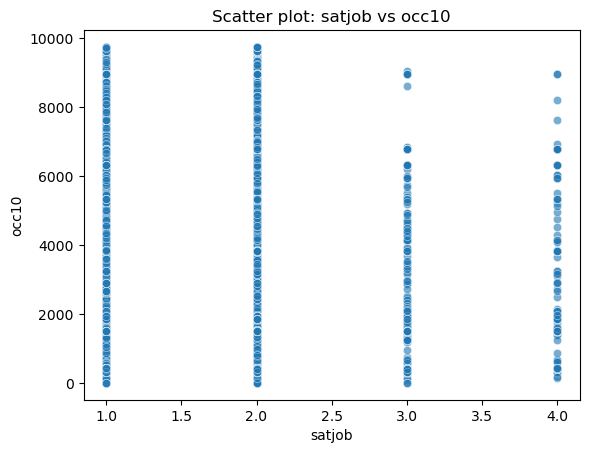

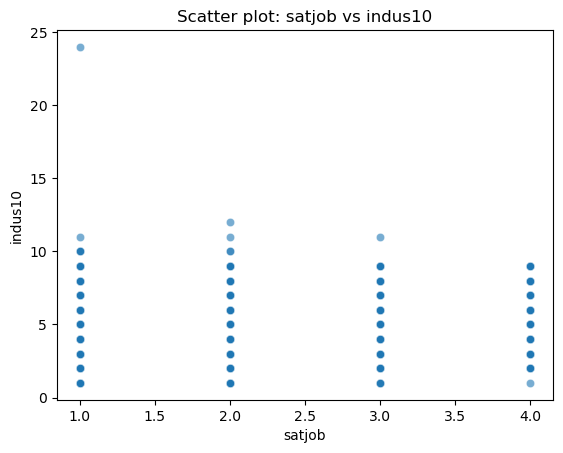

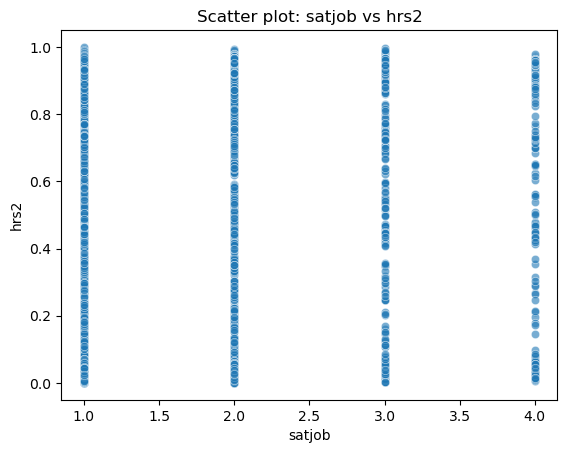

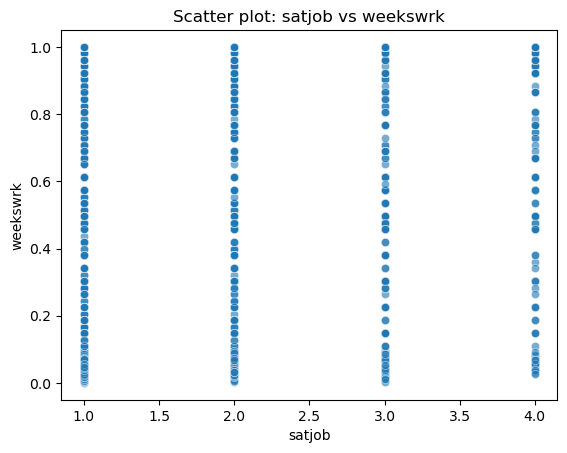

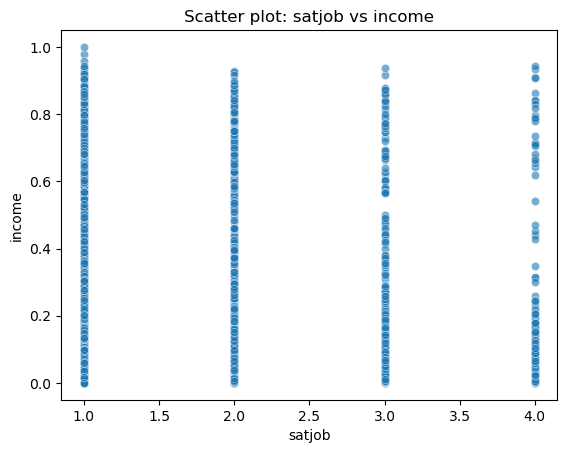

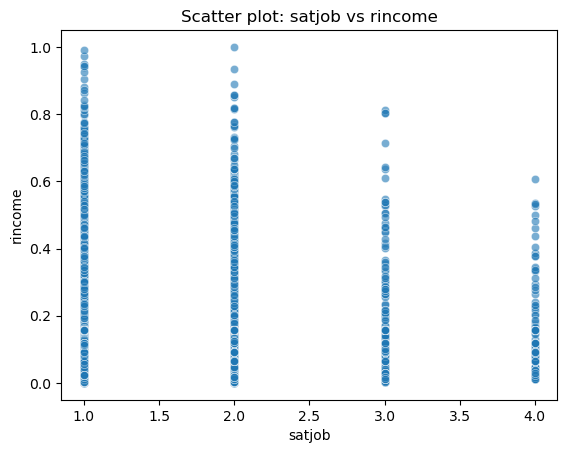

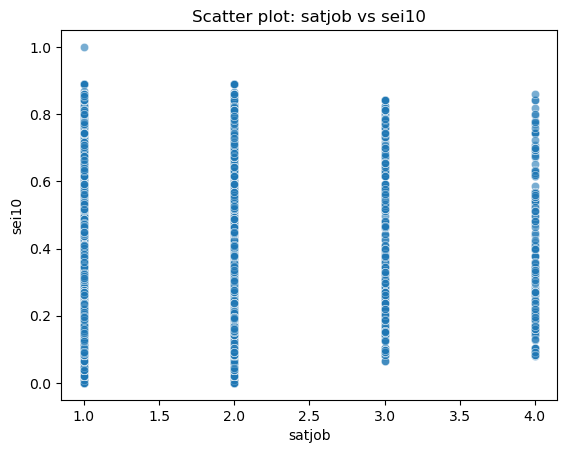

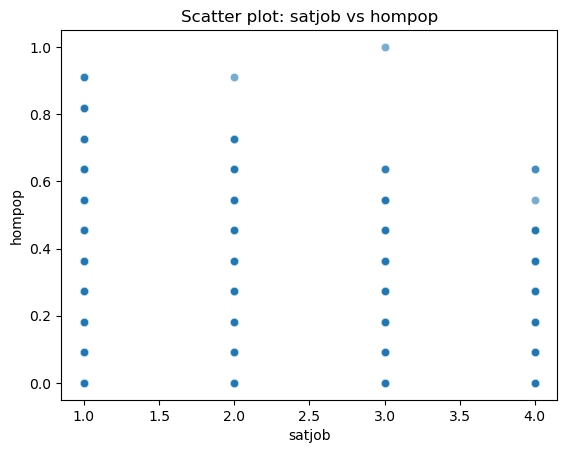

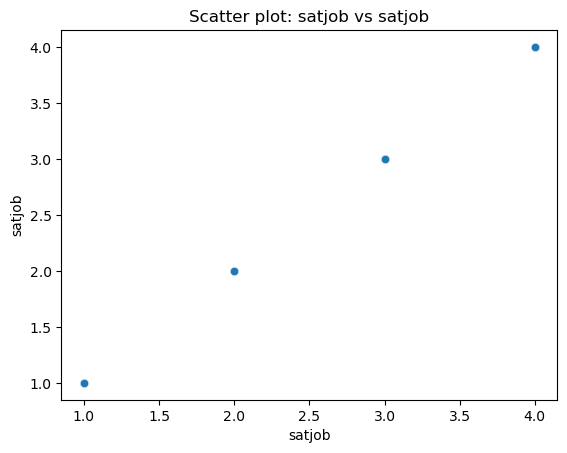

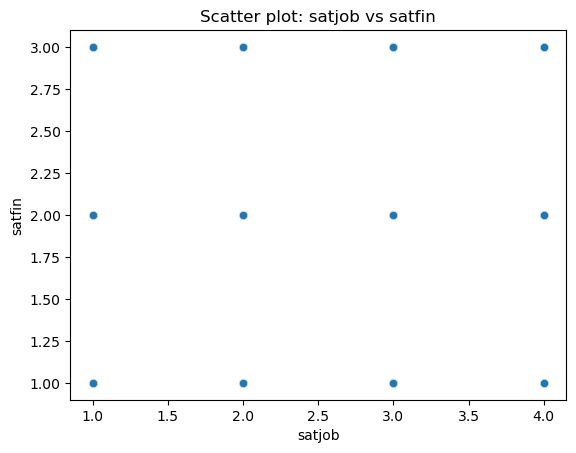

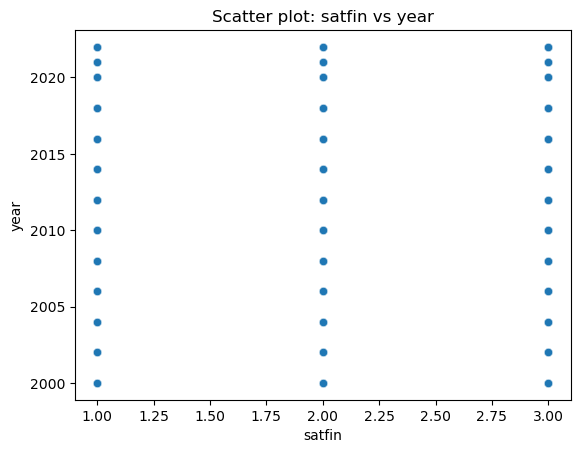

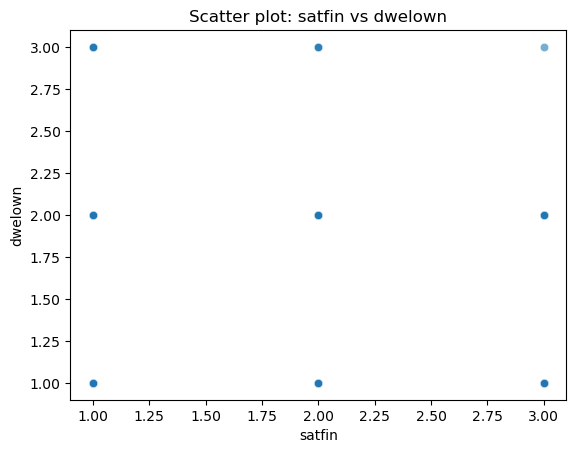

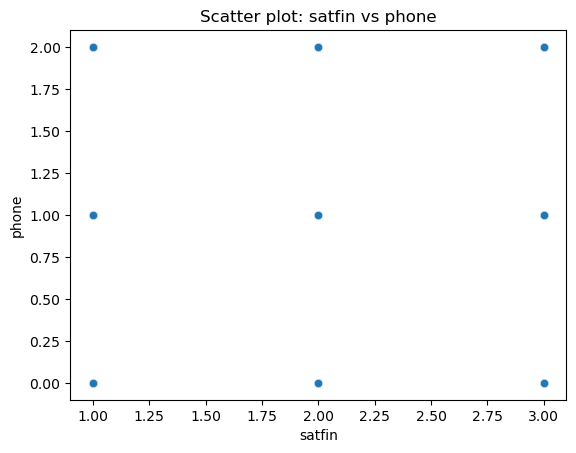

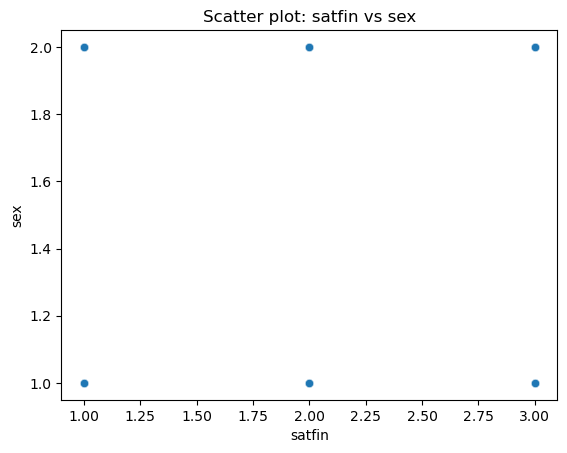

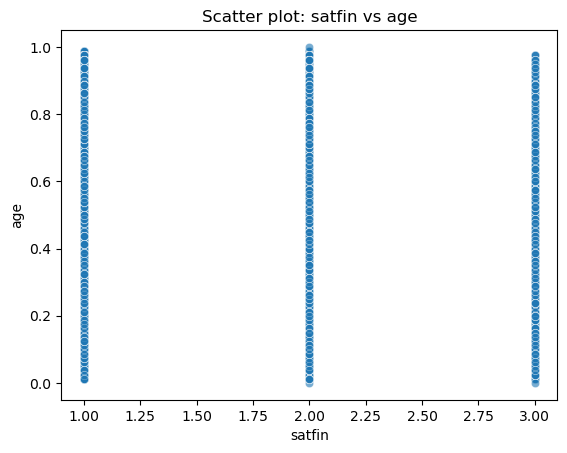

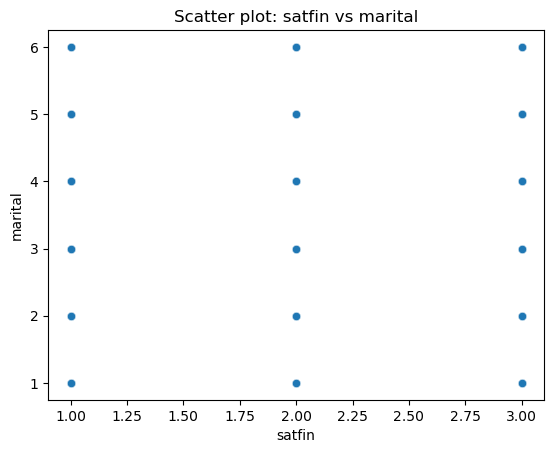

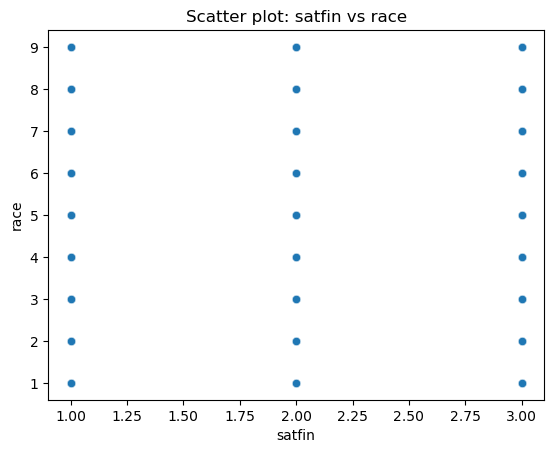

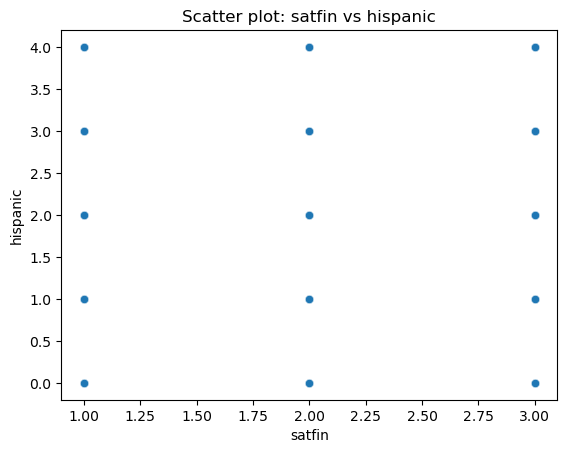

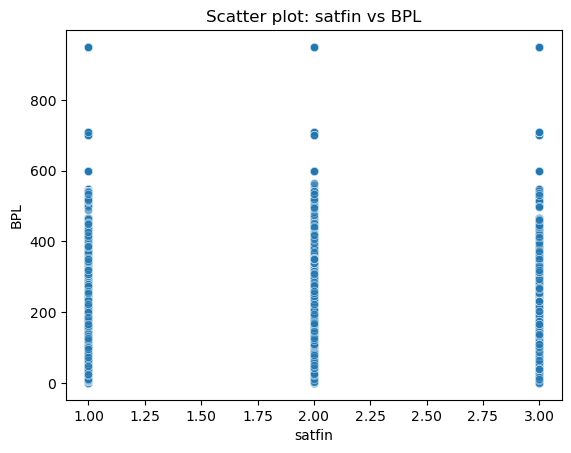

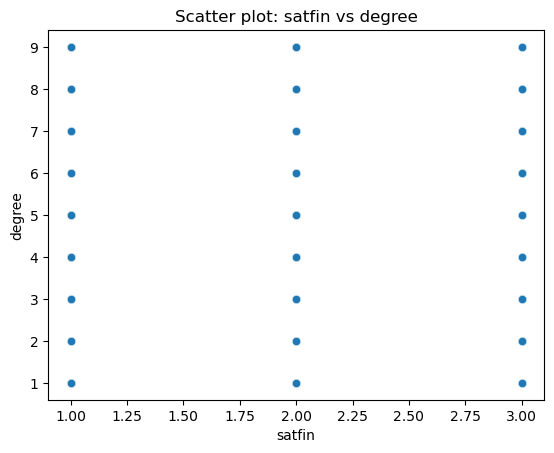

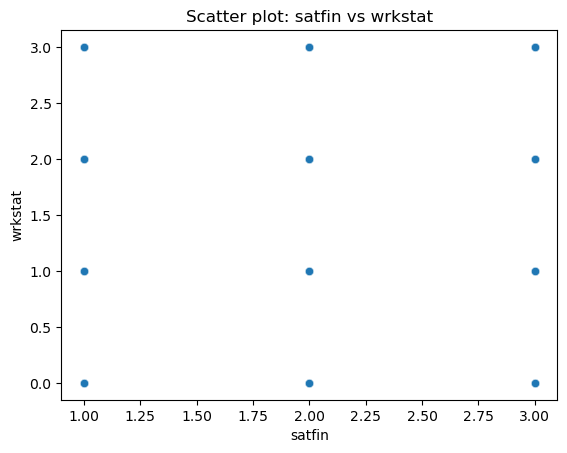

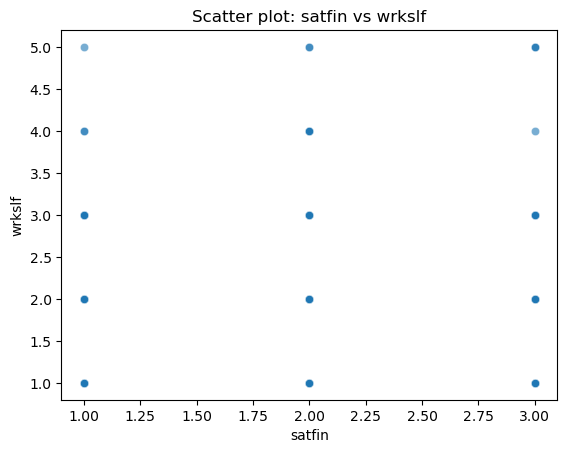

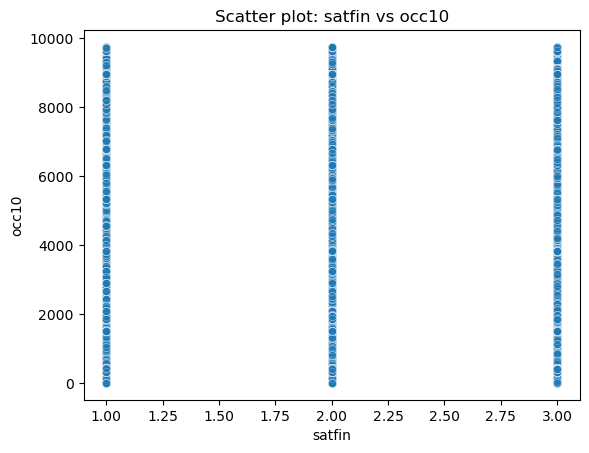

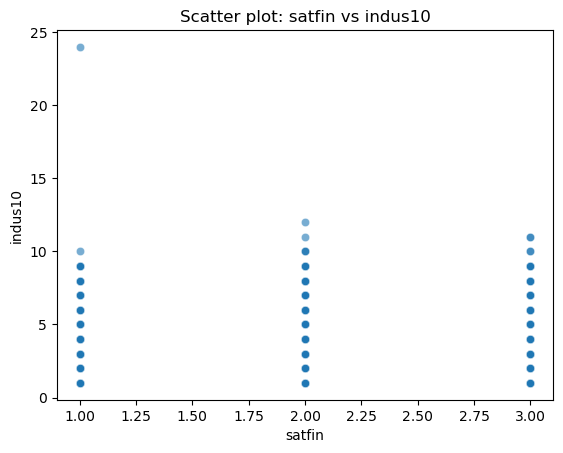

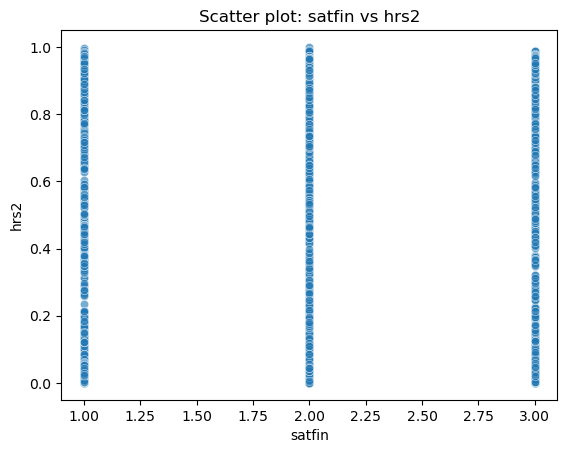

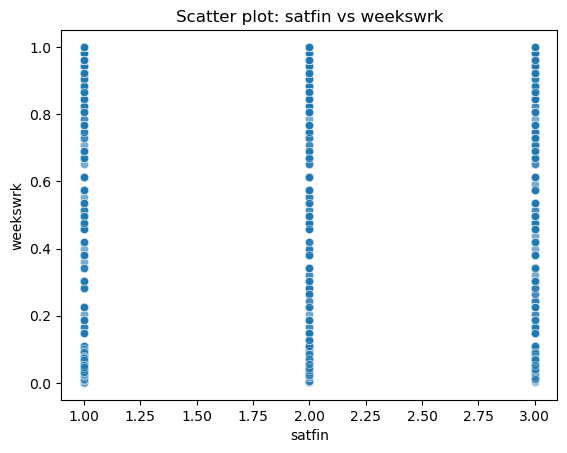

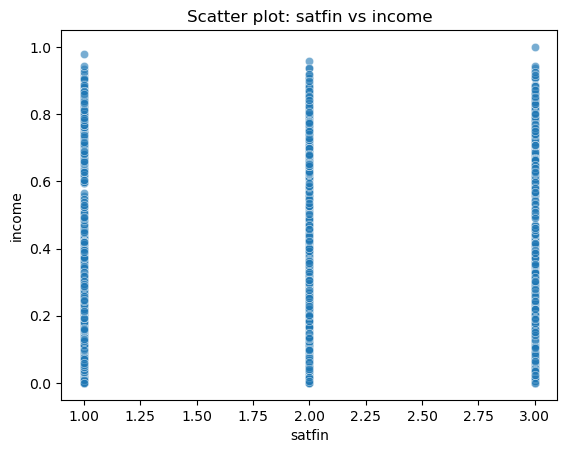

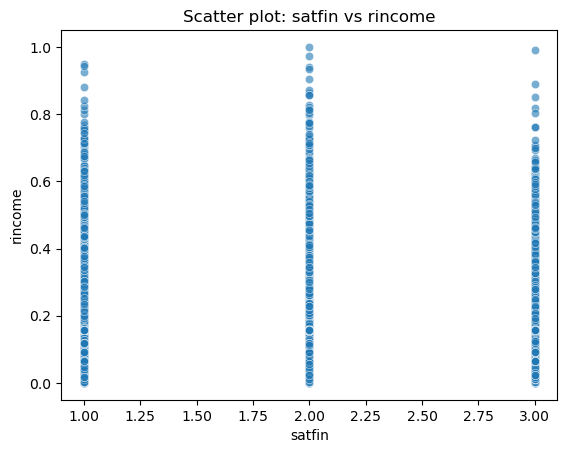

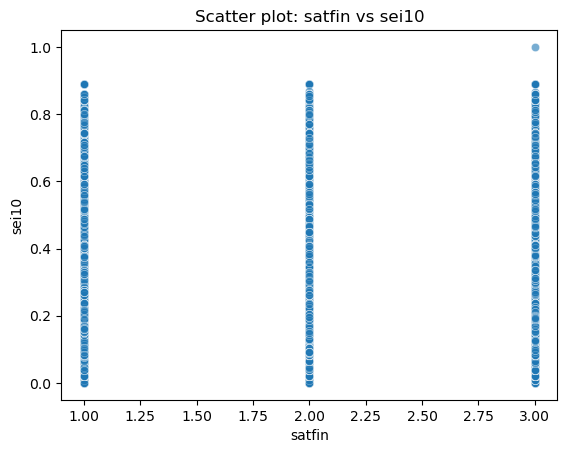

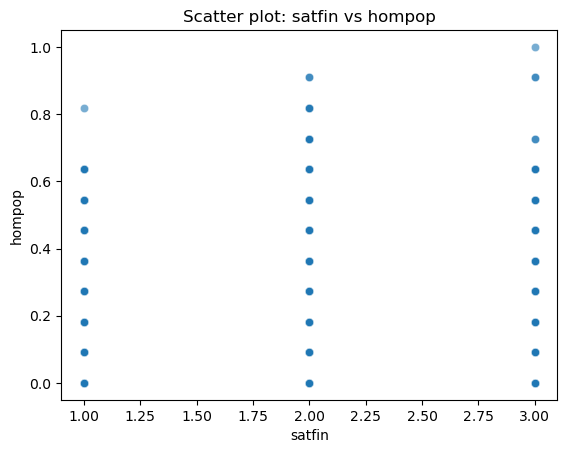

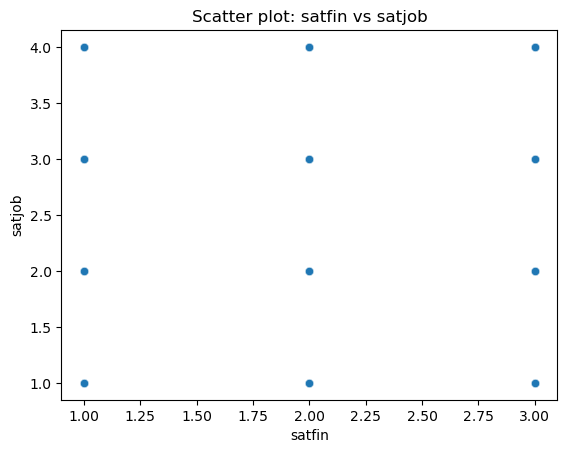

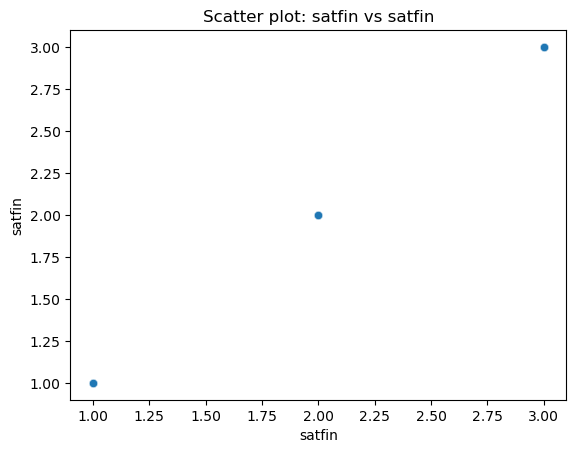


Time correlation. How does {label_name} correlates to / changes in each year?


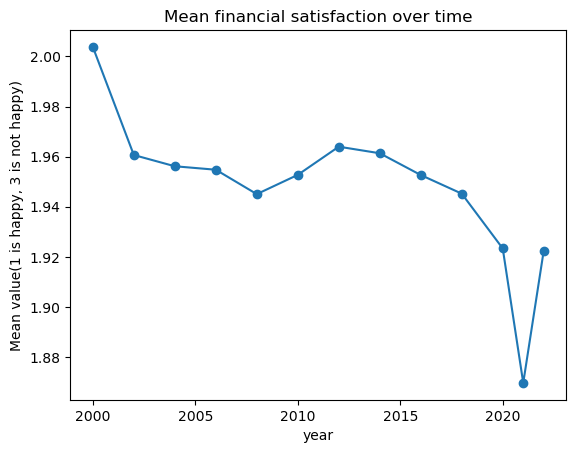


Heatmap
              year   dwelown     phone       sex       age   marital  \
year      1.000000  0.016693  0.016872  0.006632  0.080323  0.071640   
dwelown   0.016693  1.000000 -0.087769  0.006575 -0.254894  0.274438   
phone     0.016872 -0.087769  1.000000  0.014269  0.051994 -0.061410   
sex       0.006632  0.006575  0.014269  1.000000 -0.000250  0.022275   
age       0.080323 -0.254894  0.051994 -0.000250  1.000000 -0.288694   
marital   0.071640  0.274438 -0.061410  0.022275 -0.288694  1.000000   
race      0.090988  0.130759 -0.017551 -0.000834 -0.103082  0.063532   
hispanic  0.045442  0.109907 -0.018439 -0.005346 -0.083494  0.043174   
BPL       0.031949  0.085462 -0.000280 -0.010237 -0.007882 -0.044377   
degree    0.032776 -0.062166  0.045784  0.056078  0.023826 -0.063525   
wrkstat  -0.139382  0.003665 -0.016353  0.050868  0.119205 -0.010581   
wrkslf   -0.007653  0.060061 -0.010252  0.083757 -0.139669  0.073933   
occ10    -0.052942  0.043532 -0.035533 -0.156505 -0.035

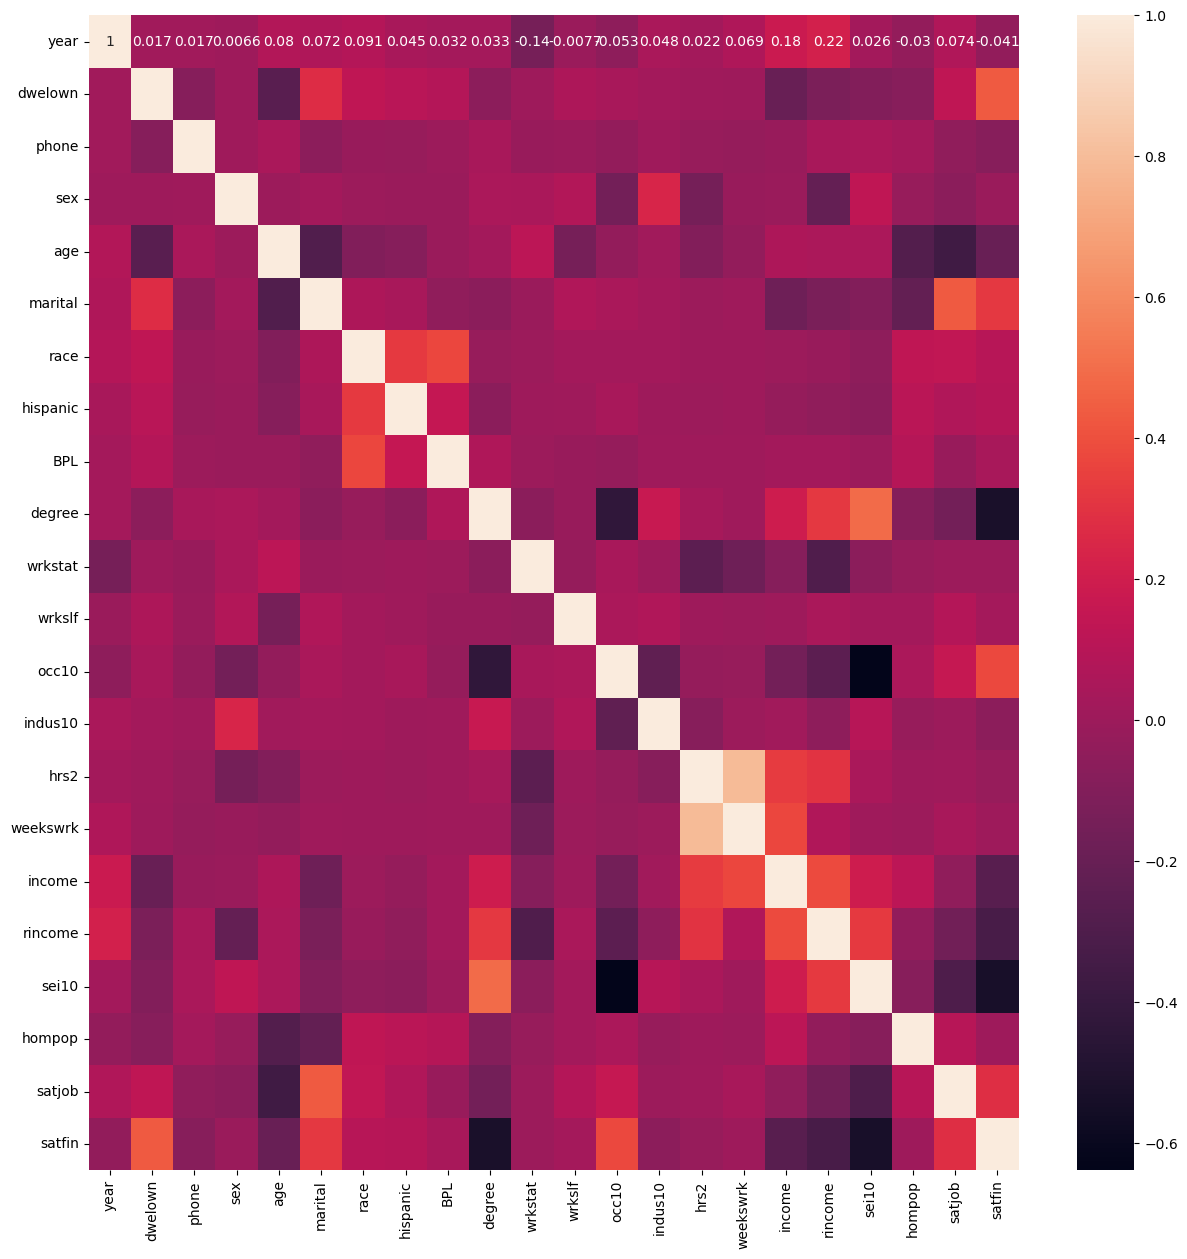

In [31]:
# Satfin
analyze("satfin")

In [8]:
# Get satfin and satjob value count among people with grad and undergrad
cleaned = pd.read_parquet("../df_preprocessed_with_predictions2.parquet")

grad = cleaned.loc[cleaned["degree"] >= 7, ["satfin", "satjob"]]
undergrad = cleaned.loc[cleaned["degree"] < 7, ["satfin", "satjob"]]

print("People with the graduate degree, statistics")
print(grad["satfin"].value_counts(normalize=True)*100)
print(grad["satjob"].value_counts(normalize=True)*100)

print("\nPeople with the undergraduate degree, statistics")
print(undergrad["satfin"].value_counts(normalize=True)*100)
print(undergrad["satjob"].value_counts(normalize=True)*100)


People with the graduate degree, statistics
satfin
1.0    70.000119
2.0    27.455319
3.0     2.544562
Name: proportion, dtype: float64
satjob
1.0    97.857653
2.0     2.138179
3.0     0.003036
4.0     0.001131
Name: proportion, dtype: float64

People with the undergraduate degree, statistics
satfin
2.0    67.183400
3.0    18.740438
1.0    14.076162
Name: proportion, dtype: float64
satjob
1.0    89.871602
2.0    10.123649
3.0     0.003225
4.0     0.001524
Name: proportion, dtype: float64
